In [7]:
import sys
sys.path.append("../../")

import numpy as np
import pandas as pd
import xgboost as xgb
from xgboost import XGBRegressor
from xgboost import plot_importance
import shap
import pickle
import json
from datetime import datetime

from pred_utils.pred_utils import rmsle_exp, cross_val_split
from data_prep.prepare_data import prepare_data

from prediction_branches.one_model_with_macro.configs.columns import flats_param_columns, \
    custom_flats_param_columns, macro_cols
from prediction_branches.one_model_with_macro.custom_funcs.funcs import manual_processing

import matplotlib.pyplot as plt

shap.initjs()

In [8]:
train_df = pd.read_csv("../../data/train.csv", parse_dates=['timestamp'])
test_df = pd.read_csv("../../data/test.csv", parse_dates=['timestamp'])
macro_df = pd.read_csv("../../data/macro.csv", parse_dates=['timestamp'])

USE_FEATURES = flats_param_columns + custom_flats_param_columns + macro_cols
train_df_processed, test_df_processed, Y_log1p = prepare_data(
    train_df, test_df, macro_df, USE_FEATURES,
    dont_touch_cols=["build_year", "timestamp", "material", "max_floor", "timestamp_year_month"]
)
train_df_processed = manual_processing(train_df_processed)
test_df_processed = manual_processing(test_df_processed)


model_name = "xgb_0.81_model_2019_04_07_22_36_one_model_with_macro"
model = pickle.load(open("../trained_models/" + model_name + ".dat", "rb"))

X = train_df_processed.copy()
del X["timestamp_year_month"]

X_test = test_df_processed.copy()
del X_test["timestamp_year_month"]

pred_test_log1p = model.predict(X_test)
pred_test = np.expm1(pred_test_log1p)

In [9]:
pd.DataFrame(model.get_booster().get_score(importance_type='weight'), index=["Importance"]).T.sort_values(
    "Importance", ascending=False)

,Importance
full_sq,116
sadovoe_km,32
edu_culture_service_km,20
transaction_since_build,20
indust_part,18
fitness_service_km,18
floor,17
big_road1_km,16
green_zone_km,15
state,15


In [10]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X)

# shap.force_plot(explainer.expected_value, shap_values[0,:], X.iloc[0,:], 
#                 feature_names=None, 
#                 out_names=None, link="identity",
#                 plot_cmap="RdBu", 
#                 matplotlib=True, show=True, 
#                 figsize=(20,3), 
#                 ordering_keys=None, ordering_keys_time_format=None,
#                 text_rotation=90)

shap.force_plot(explainer.expected_value, shap_values[0:100,:], X.iloc[0:100,:], show=True)

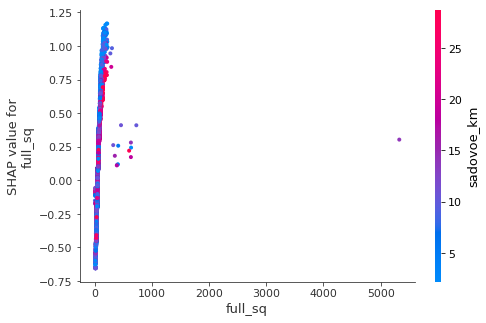

In [11]:
shap.dependence_plot("full_sq", shap_values, X, show=False)

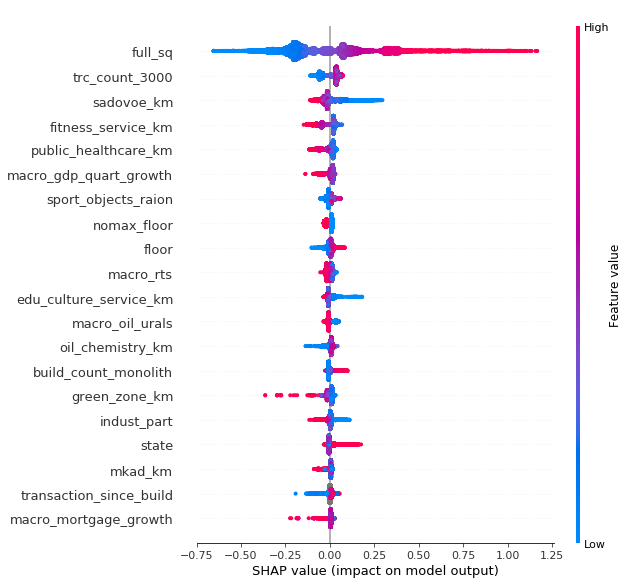

In [12]:
shap.summary_plot(shap_values, X)

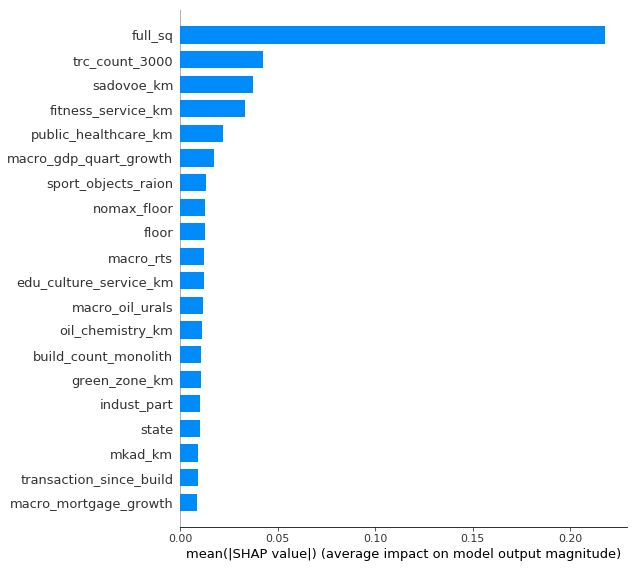

In [13]:
shap.summary_plot(shap_values, X, plot_type="bar")